In [4]:
from pypinyin import lazy_pinyin, Style
import torch
from pydub import  AudioSegment
import numpy as np
from ttts.utils import vc_utils

MODELS = {
    'vqvae.pth':'/home/hyc/tortoise_plus_zh/ttts/vqvae/logs/2024-03-03-17-12-56/model-145.pt',
    'gpt.pth': '/home/hyc/tortoise_plus_zh/ttts/gpt/logs/2024-03-04-03-09-09/model-45.pt',
    'clvp2.pth': '',
    'diffusion.pth': '/home/hyc/tortoise_plus_zh/ttts/diffusion/logs/2024-02-24-11-42-36/model-57.pt',
    'vocoder.pth': '~/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin',
    'rlg_auto.pth': '',
    'rlg_diffuser.pth': '',
}

In [15]:
from ttts.gpt.voice_tokenizer import VoiceBpeTokenizer
import torch.nn.functional as F
cond_audio = '8.wav'
# cond_text = "霞浦县衙城镇乌旗瓦窑村水位猛涨。"
# cond_text = "现场都是人，五辆警车好不容易找到位置停下。"
# cond_text = "除了曾经让全人类都畏惧的麻疹和天花之外，传染率"
# cond_text = "开始步行导航，今天我也是没有迟到哦。"
# cond_text = "这是县交警队的一个小据点。"
# cond_text = "没什么，没什么，只是平时他总是站在这里，有点奇怪而已。"
cond_text = "没错没错，就是这样。"

device = 'cuda:1'
text = "没错没错，就是这样。"
# text = "没什么，没什么，只是平时他总是站在这里，有点奇怪而已。"
# text = "大家好，今天来点大家想看的东西。"
# text = "霞浦县衙城镇乌旗瓦窑村水位猛涨。"
# text = '高德官方网站，拥有全面、精准的地点信息，公交驾车路线规划，特色语音导航，商家团购、优惠信息。'
# text = '四是四，十是十，十四是十四，四十是四十。'
# text = '八百标兵奔北坡，炮兵并排北边跑。炮兵怕把标兵碰，标兵怕碰炮兵炮。'
# text = '黑化肥发灰，灰化肥发黑。黑化肥挥发会发灰，灰化肥挥发会发黑。'
# text = '先帝创业未半而中道崩殂，今天下三分，益州疲弊，此诚危急存亡之秋也。然侍卫之臣不懈于内，忠志之士忘身于外者，盖追先帝之殊遇，欲报之于陛下也。诚宜开张圣听，以光先帝遗德，恢弘志士之气，不宜妄自菲薄，引喻失义，以塞忠谏之路也。'
text = cond_text + text
pinyin = ' '.join(lazy_pinyin(text, style=Style.TONE3, neutral_tone_with_five=True))
tokenizer = VoiceBpeTokenizer('gpt/gpt_tts_tokenizer.json')
text_tokens = torch.IntTensor(tokenizer.encode(pinyin)).unsqueeze(0).to(device)
text_tokens = F.pad(text_tokens, (0, 1))  # This may not be necessary.
text_tokens = text_tokens.to(device)
print(pinyin)
print(text_tokens)

mei2 cuo4 mei2 cuo4 ， jiu4 shi4 zhe4 yang4 。 mei2 cuo4 mei2 cuo4 ， jiu4 shi4 zhe4 yang4 。
tensor([[243,   2,  11, 110,   2, 243,   2,  11, 110,   2,  43,   2, 219,   2,
          77,   2, 154,   2,  33,  82,   2,  39,   2, 243,   2,  11, 110,   2,
         243,   2,  11, 110,   2,  43,   2, 219,   2,  77,   2, 154,   2,  33,
          82,   2,  39,   0]], device='cuda:1', dtype=torch.int32)


In [16]:
from ttts.utils.infer_utils import load_model
from ttts.vocoder.feature_extractors import MelSpectrogramFeatures
import torchaudio
from ttts.utils import cnhubert
import torchaudio.functional as F
# device = 'gpu:0'
gpt = load_model('gpt',MODELS['gpt.pth'],'gpt/config.json',device)
gpt.post_init_gpt2_config(use_deepspeed=False, kv_cache=False, half=False)
# cnhubert.cnhubert_base_path = '/home/hyc/tortoise_plus_zh/ttts/pretrained_models/chinese-hubert-base'
# hmodel=cnhubert.get_model().to(device)
wav, sr = torchaudio.load(cond_audio)
if wav.shape[0] > 1:  # mix to mono
    wav = wav.mean(dim=0, keepdim=True)
wav24k = F.resample(wav, sr, 24000)
wav24k = wav24k.to(device)
mel_extractor = MelSpectrogramFeatures().to(device)
cond_mel =  mel_extractor(wav24k)
cond_mel = cond_mel.to(device)
vqvae = load_model('vqvae', MODELS['vqvae.pth'], 'vqvae/config.json', device)
cond_melvq = vqvae.extract_code(cond_mel).squeeze(0)
print(cond_melvq)

/home/hyc/miniconda3/envs/vocos/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


tensor([[ 993,   77,  549, 1020,   28,  361,  717,  799,  426,  435, 1020,   28,
          361,  401,  664,   21,  841,  943,  450,  285,  284,  752,  447,  361,
          928,  126,  742,  779, 1020,  427,  842,  219,  992,  372,  606,  207,
          147,  689,    1,  732]], device='cuda:1')


In [78]:
settings = {'temperature': .8, 'length_penalty': 1.0, 'repetition_penalty': 2.0,
                    'top_p': .8,
                    'cond_free_k': 2.0, 'diffusion_temperature': 1.0}
top_p = .8
temperature = .8
autoregressive_batch_size = 1
length_penalty = 2.0
repetition_penalty = 2.0
max_mel_tokens = 1000
print(text_tokens)
print(cond_melvq)
# text_tokens = F.pad(text_tokens,(0,400-text_tokens.shape[1]),value=0)
codes = gpt.inference_speech(text_tokens,
                                cond_melvq,
                                do_sample=True,
                                top_p=top_p,
                                temperature=temperature,
                                num_return_sequences=autoregressive_batch_size,
                                length_penalty=length_penalty,
                                repetition_penalty=repetition_penalty,
                                max_generate_length=max_mel_tokens)
print(codes)


tensor([[243,   2,  11, 110,   2, 243,   2,  11, 110,   2,  43,   2, 219,   2,
          77,   2, 154,   2,  33,  82,   2,  39,   2, 243,   2,  11, 110,   2,
         243,   2,  11, 110,   2,  43,   2, 219,   2,  77,   2, 154,   2,  33,
          82,   2,  39,   0]], device='cuda:1', dtype=torch.int32)
tensor([[ 993,   77,  549, 1020,   28,  361,  717,  799,  426,  435, 1020,   28,
          361,  401,  664,   21,  841,  943,  450,  285,  284,  752,  447,  361,
          928,  126,  742,  779, 1020,  427,  842,  219,  992,  372,  606,  207,
          147,  689,    1,  732]], device='cuda:1')
tensor([[ 913,  633,  781,  753,   75,    6,  396,  947,  951,  891,  149,  721,
          618,  501,  430,    0,  859,  718,  523,  996,  826,  878,  783,  914,
          620,  726,  216,  150,  393,  566,   76,  929,  832,  225,    4,   57,
          960,  727,  646,  143,  987,  218,  909,  293,  893,  581,  422,  338,
          369,  699, 1025]], device='cuda:1')


In [56]:
mel = vqvae.decode(codes[:,:-1], cond_mel)
mel.shape

torch.Size([1, 100, 192])

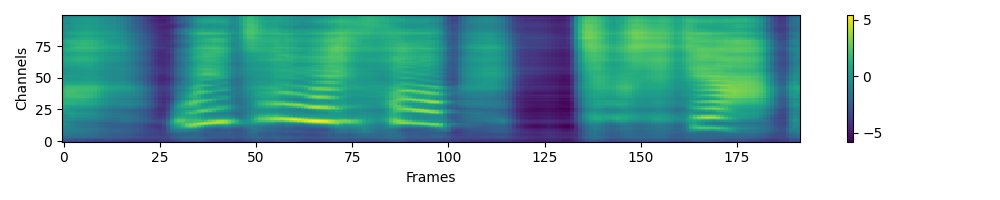

In [57]:
from PIL import Image
import numpy as np
from pydub import  AudioSegment
import torch
from IPython.display import display
import librosa
import torchaudio
import torchaudio.functional as F
from ttts.utils.utils import plot_spectrogram_to_numpy
img = plot_spectrogram_to_numpy(mel[0, :, :].detach().unsqueeze(-1).cpu())
image = Image.fromarray(np.uint8(img))
display(image)

In [38]:
from ttts.vocoder.vocos import Vocos


vocos = Vocos.from_pretrained('pretrained_models/pytorch_model.bin','vocoder/config.yaml').to(device)
audio = vocos.decode(mel)
print(audio.shape)
torchaudio.save('gen0.wav',audio.detach().cpu(), 24000)

torch.Size([1, 47872])


In [8]:
latent = gpt(auto_conditioning, text_tokens,
    torch.tensor([text_tokens.shape[-1]], device=text_tokens.device), codes,
    torch.tensor([codes.shape[-1]*gpt.mel_length_compression], device=text_tokens.device),
    return_latent=True, clip_inputs=False).transpose(1,2)
latent.shape

NameError: name 'auto_conditioning' is not defined

In [64]:
from ttts.diffusion.train import do_spectrogram_diffusion
from ttts.utils.diffusion import SpacedDiffusion, space_timesteps, get_named_beta_schedule
from ttts.diffusion.aa_model import denormalize_tacotron_mel, normalize_tacotron_mel
# print(device)
diffusion = load_model('diffusion',MODELS['diffusion.pth'],'diffusion/config.yaml',device)
diffuser = SpacedDiffusion(use_timesteps=space_timesteps(1000, [50]), model_mean_type='epsilon',
                           model_var_type='learned_range', loss_type='mse', betas=get_named_beta_schedule('linear', 1000),
                           conditioning_free=True, conditioning_free_k=2., sampler='dpm++2m')
diffusion_conditioning = normalize_tacotron_mel(cond_mel)
mel = do_spectrogram_diffusion(diffusion, diffuser, latent, diffusion_conditioning, temperature=1.0)
wav = vocos.decode(mel)

Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up Memo

100%|██████████| 50/50 [00:04<00:00, 10.10it/s]


In [65]:
from IPython.display import Audio
wav = wav.detach().cpu()
torchaudio.save('gen.wav',wav.detach().cpu(), 24000)
Audio(wav,rate=24000)

In [11]:
# from ttts.vocoder.vocos import Vocos
# from IPython.display import Audio
# vocoder = Vocos.from_pretrained("~/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin","~/tortoise_plus_zh/ttts/vocoder/config.yaml")
# audio = vocoder.decode(mel.cpu())
# torchaudio.save('gen_0.wav',audio,24000)
# Audio('gen_0.wav')